# Paper folding

* <https://adventofcode.com/2021/day/13>

We are asked to fold transparent paper. Folding not only doubles the thickness of the paper (so thickness progresses exponentially), but the length of paper required in the curve of the fold _quadruples_, as famously proven by [Britney Gallivan](https://www.youtube.com/watch?v=AfPDvhKvaa0), who holds the World Record paper folding, having folded paper 12 times. An episode of the BBC OneShow made a [valliant attempt at 13 folds](https://www.youtube.com/watch?v=ZQ0QWn7Z-IQ), illustrating how hard folding paper can be! I note, with some satisfaction, that our puzzle input asks us to fold the 'paper' 12 times as well. :-)

We'll have it easier. If you model the paper as a numpy 2D boolean array, we can just use slicing and reversing, then the boolean `|` or operator to combine the markings. A quick glance at the folding lines also shows that the matrix will be folded along the exact middle each time, so we don't have to account for shifting a smaller or larger halve over the other side.


In [1]:
from __future__ import annotations

import re
from io import BytesIO
from typing import Iterable, Optional

import numpy as np
from PIL import Image


_FOLD_INSTRUCTION = re.compile(r"fold along (?P<axis>[xy])=(?P<line>\d+)").match


class TransparentOrigami:
    def __init__(self, paper: np.array) -> None:
        self._matrix = paper

    @classmethod
    def from_positions(
        cls, positions: list[str], width: int, height: int
    ) -> TransparentOrigami:
        dot_positions = np.array(
            [tuple(map(int, line.split(","))) for line in positions], dtype=np.uint
        )
        # matrix is indexed using (x, y), so is transposed from the usual (y, x)
        matrix = np.zeros((width, height), dtype=np.bool_)
        matrix[dot_positions[:, 0], dot_positions[:, 1]] = True
        return cls(matrix)

    @classmethod
    def from_instructions(cls, instructions: str) -> Iterable[TransparentOrigami]:
        positions, steps = instructions.split("\n\n")
        instr = (_FOLD_INSTRUCTION(step).groups() for step in steps.splitlines())
        steps = [{axis: int(line)} for axis, line in instr]
        width = next(x * 2 + 1 for s in steps if (x := s.get("x")))
        height = next(y * 2 + 1 for s in steps if (y := s.get("y")))
        paper = cls.from_positions(positions.splitlines(), width, height)
        yield paper
        for step in steps:
            paper = paper.fold(**step)
            yield paper

    def __str__(self) -> str:
        return np.array2string(  # transpose to (y, x) indexing for display
            self._matrix.T, separator="", formatter={"bool": ".#".__getitem__}
        ).translate(
            # Remove spaces and square brackets, [ and ]
            dict.fromkeys((0x20, 0x5B, 0x5D))
        )

    def _repr_png_(self) -> bytes:
        img = Image.fromarray(self._matrix.T)
        f = BytesIO()
        img.resize((img.width * 10, img.height * 10)).save(f, "PNG")
        return f.getvalue()

    def __len__(self) -> int:
        return self._matrix.sum()

    def fold(
        self, x: Optional[int] = None, y: Optional[int] = None
    ) -> TransparentOrigami:
        if y is not None:
            top, bottom = self._matrix[:, :y], self._matrix[:, y + 1 :]
            return type(self)(top | bottom[:, ::-1])
        else:
            left, right = self._matrix[:x, :], self._matrix[x + 1 :, :]
            return type(self)(left | right[::-1, :])


test_instructions = """\
6,10
0,14
9,10
0,3
10,4
4,11
6,0
6,12
4,1
0,13
10,12
3,4
3,0
8,4
1,10
2,14
8,10
9,0

fold along y=7
fold along x=5
"""

test_paper_folds = list(TransparentOrigami.from_instructions(test_instructions))
assert len(test_paper_folds[1]) == 17


In [2]:
import aocd

instructions = aocd.get_data(day=13, year=2021)
paper_folds = list(TransparentOrigami.from_instructions(instructions))
print("Part 1:", len(paper_folds[1]))

Part 1: 753


# Part 2, keep on folding

For part 2, we only need to display the result after following all folding instructions. I gave my origami class a [`_display_png_` method](https://ipython.readthedocs.io/en/stable/api/generated/IPython.core.formatters.html?highlight=_repr_png_#IPython.core.formatters.PNGFormatter)

Part 2:


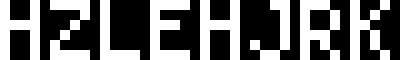

In [3]:
print("Part 2:")
paper_folds[-1]


# Each individiual folding result

I don't (yet) have the time to create an animation from this, but here are all the paper states, from the initial instructions to the final, 12th fold:

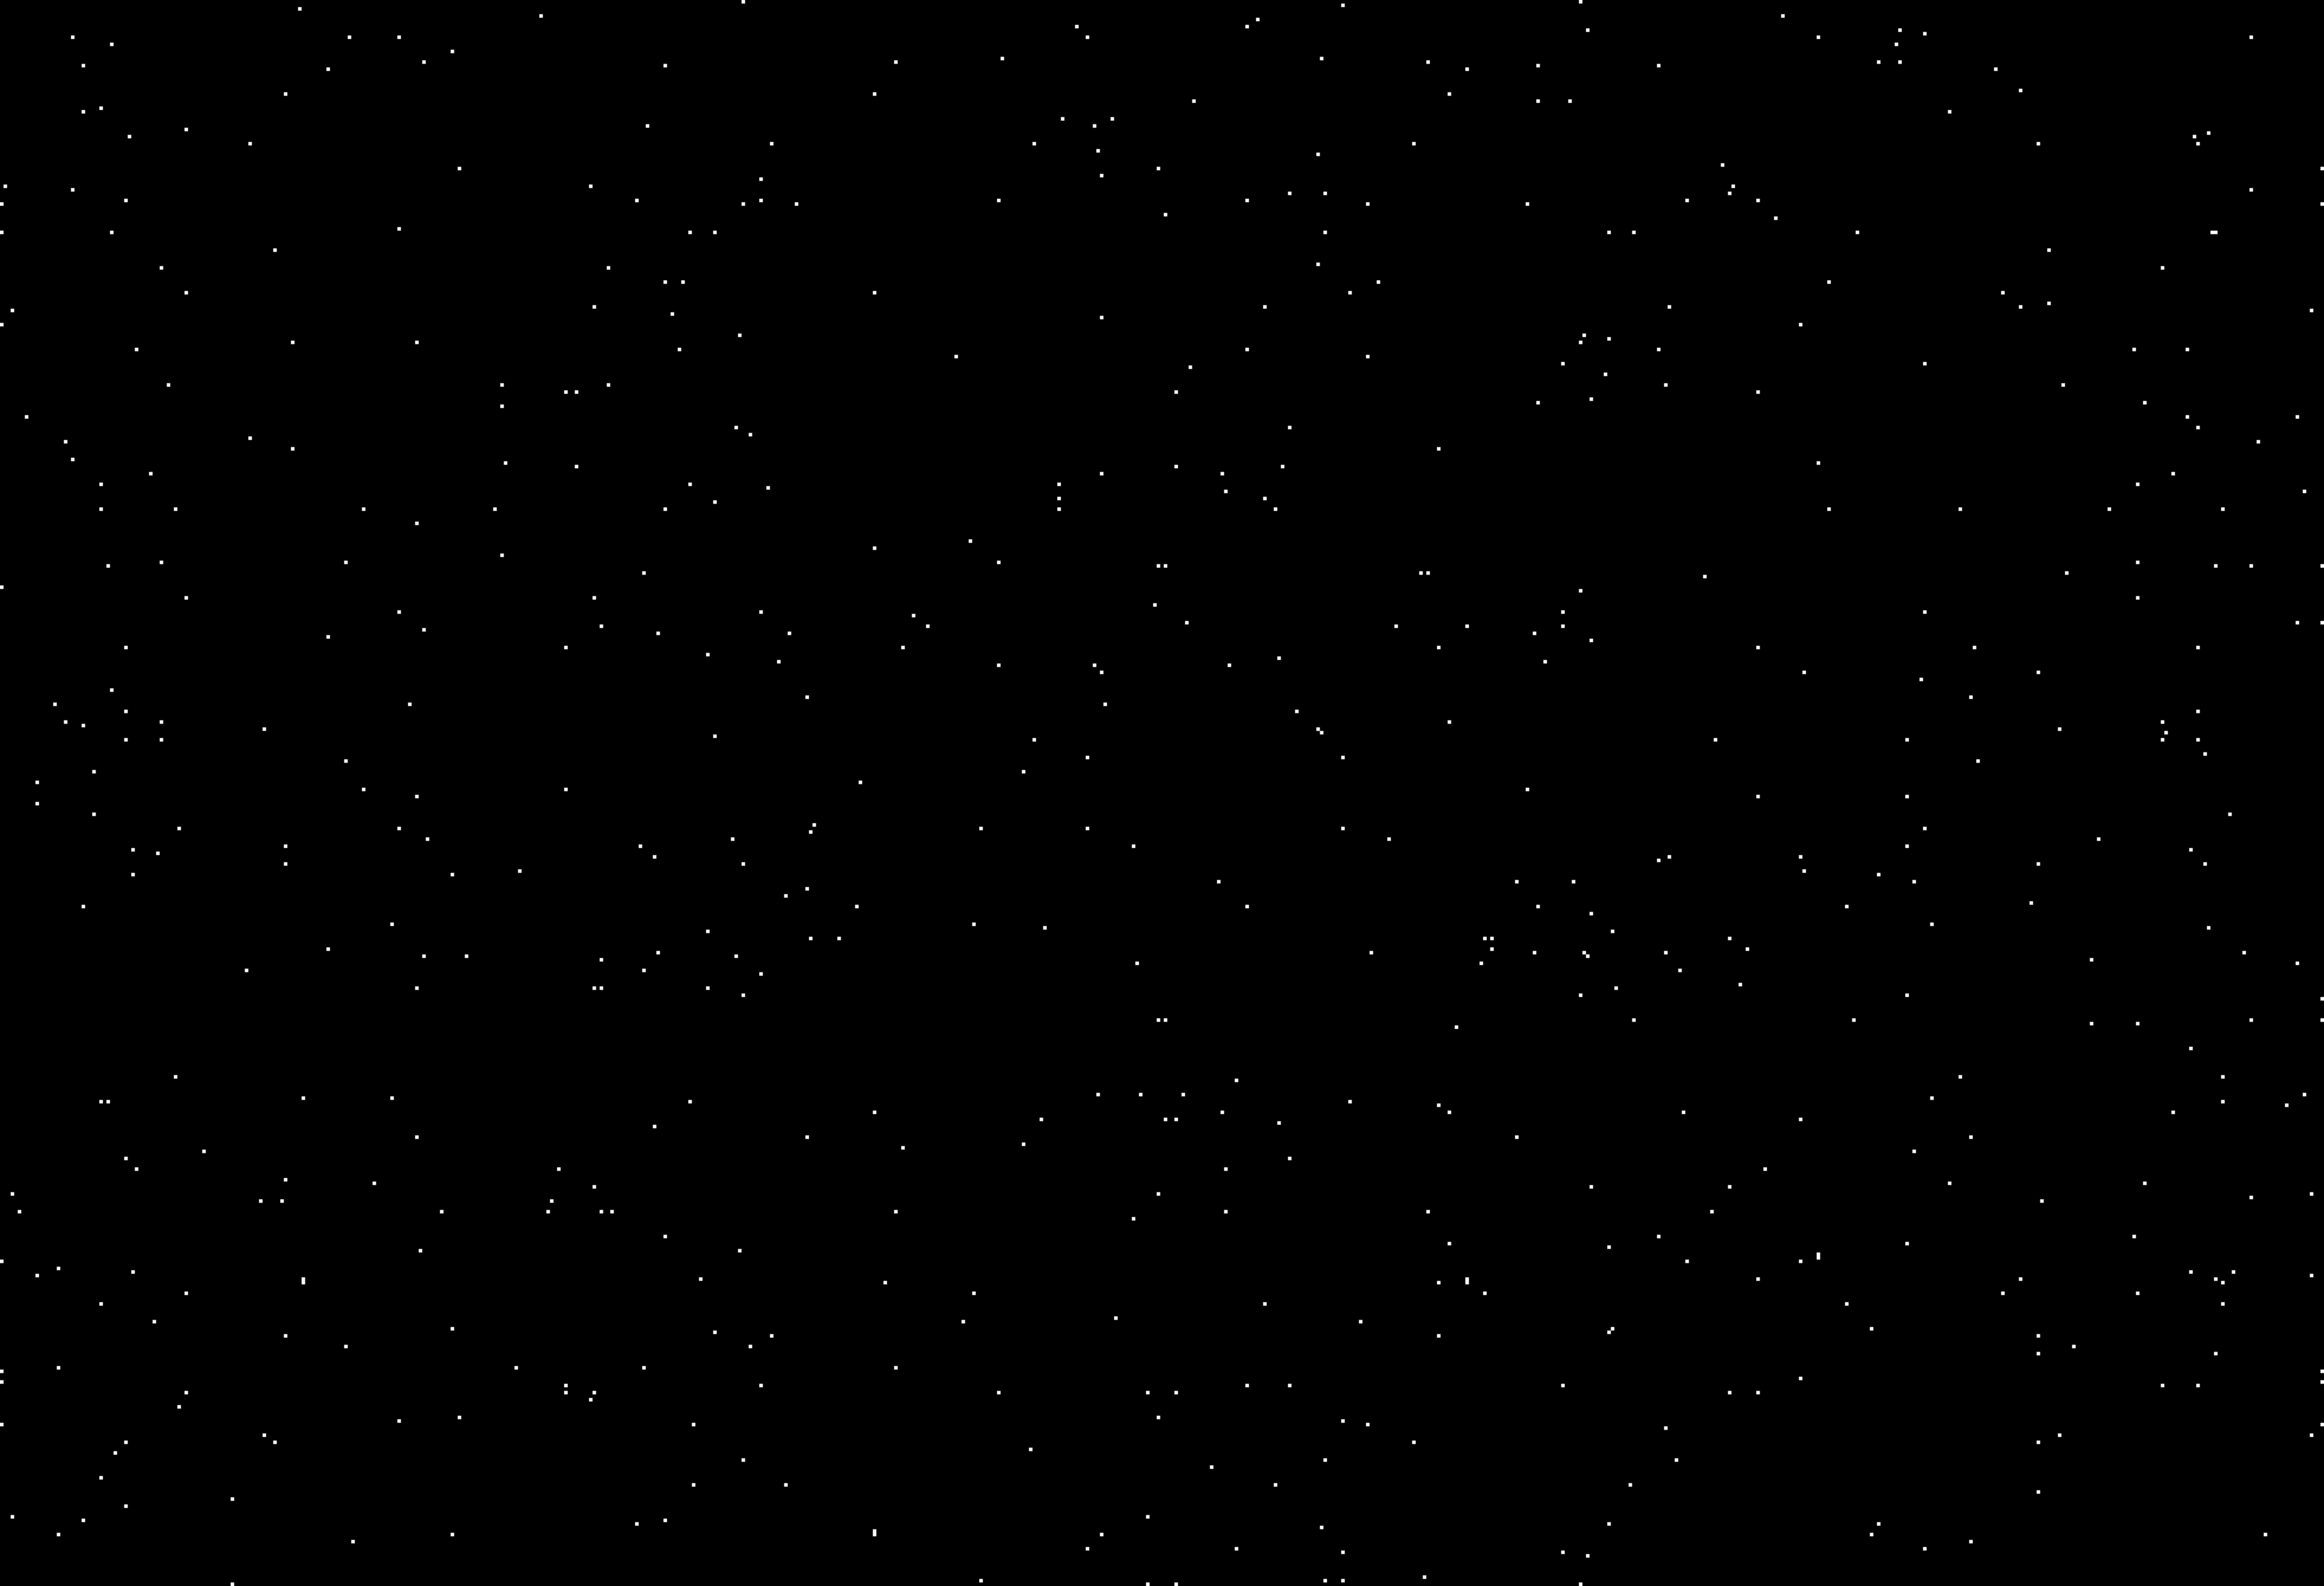

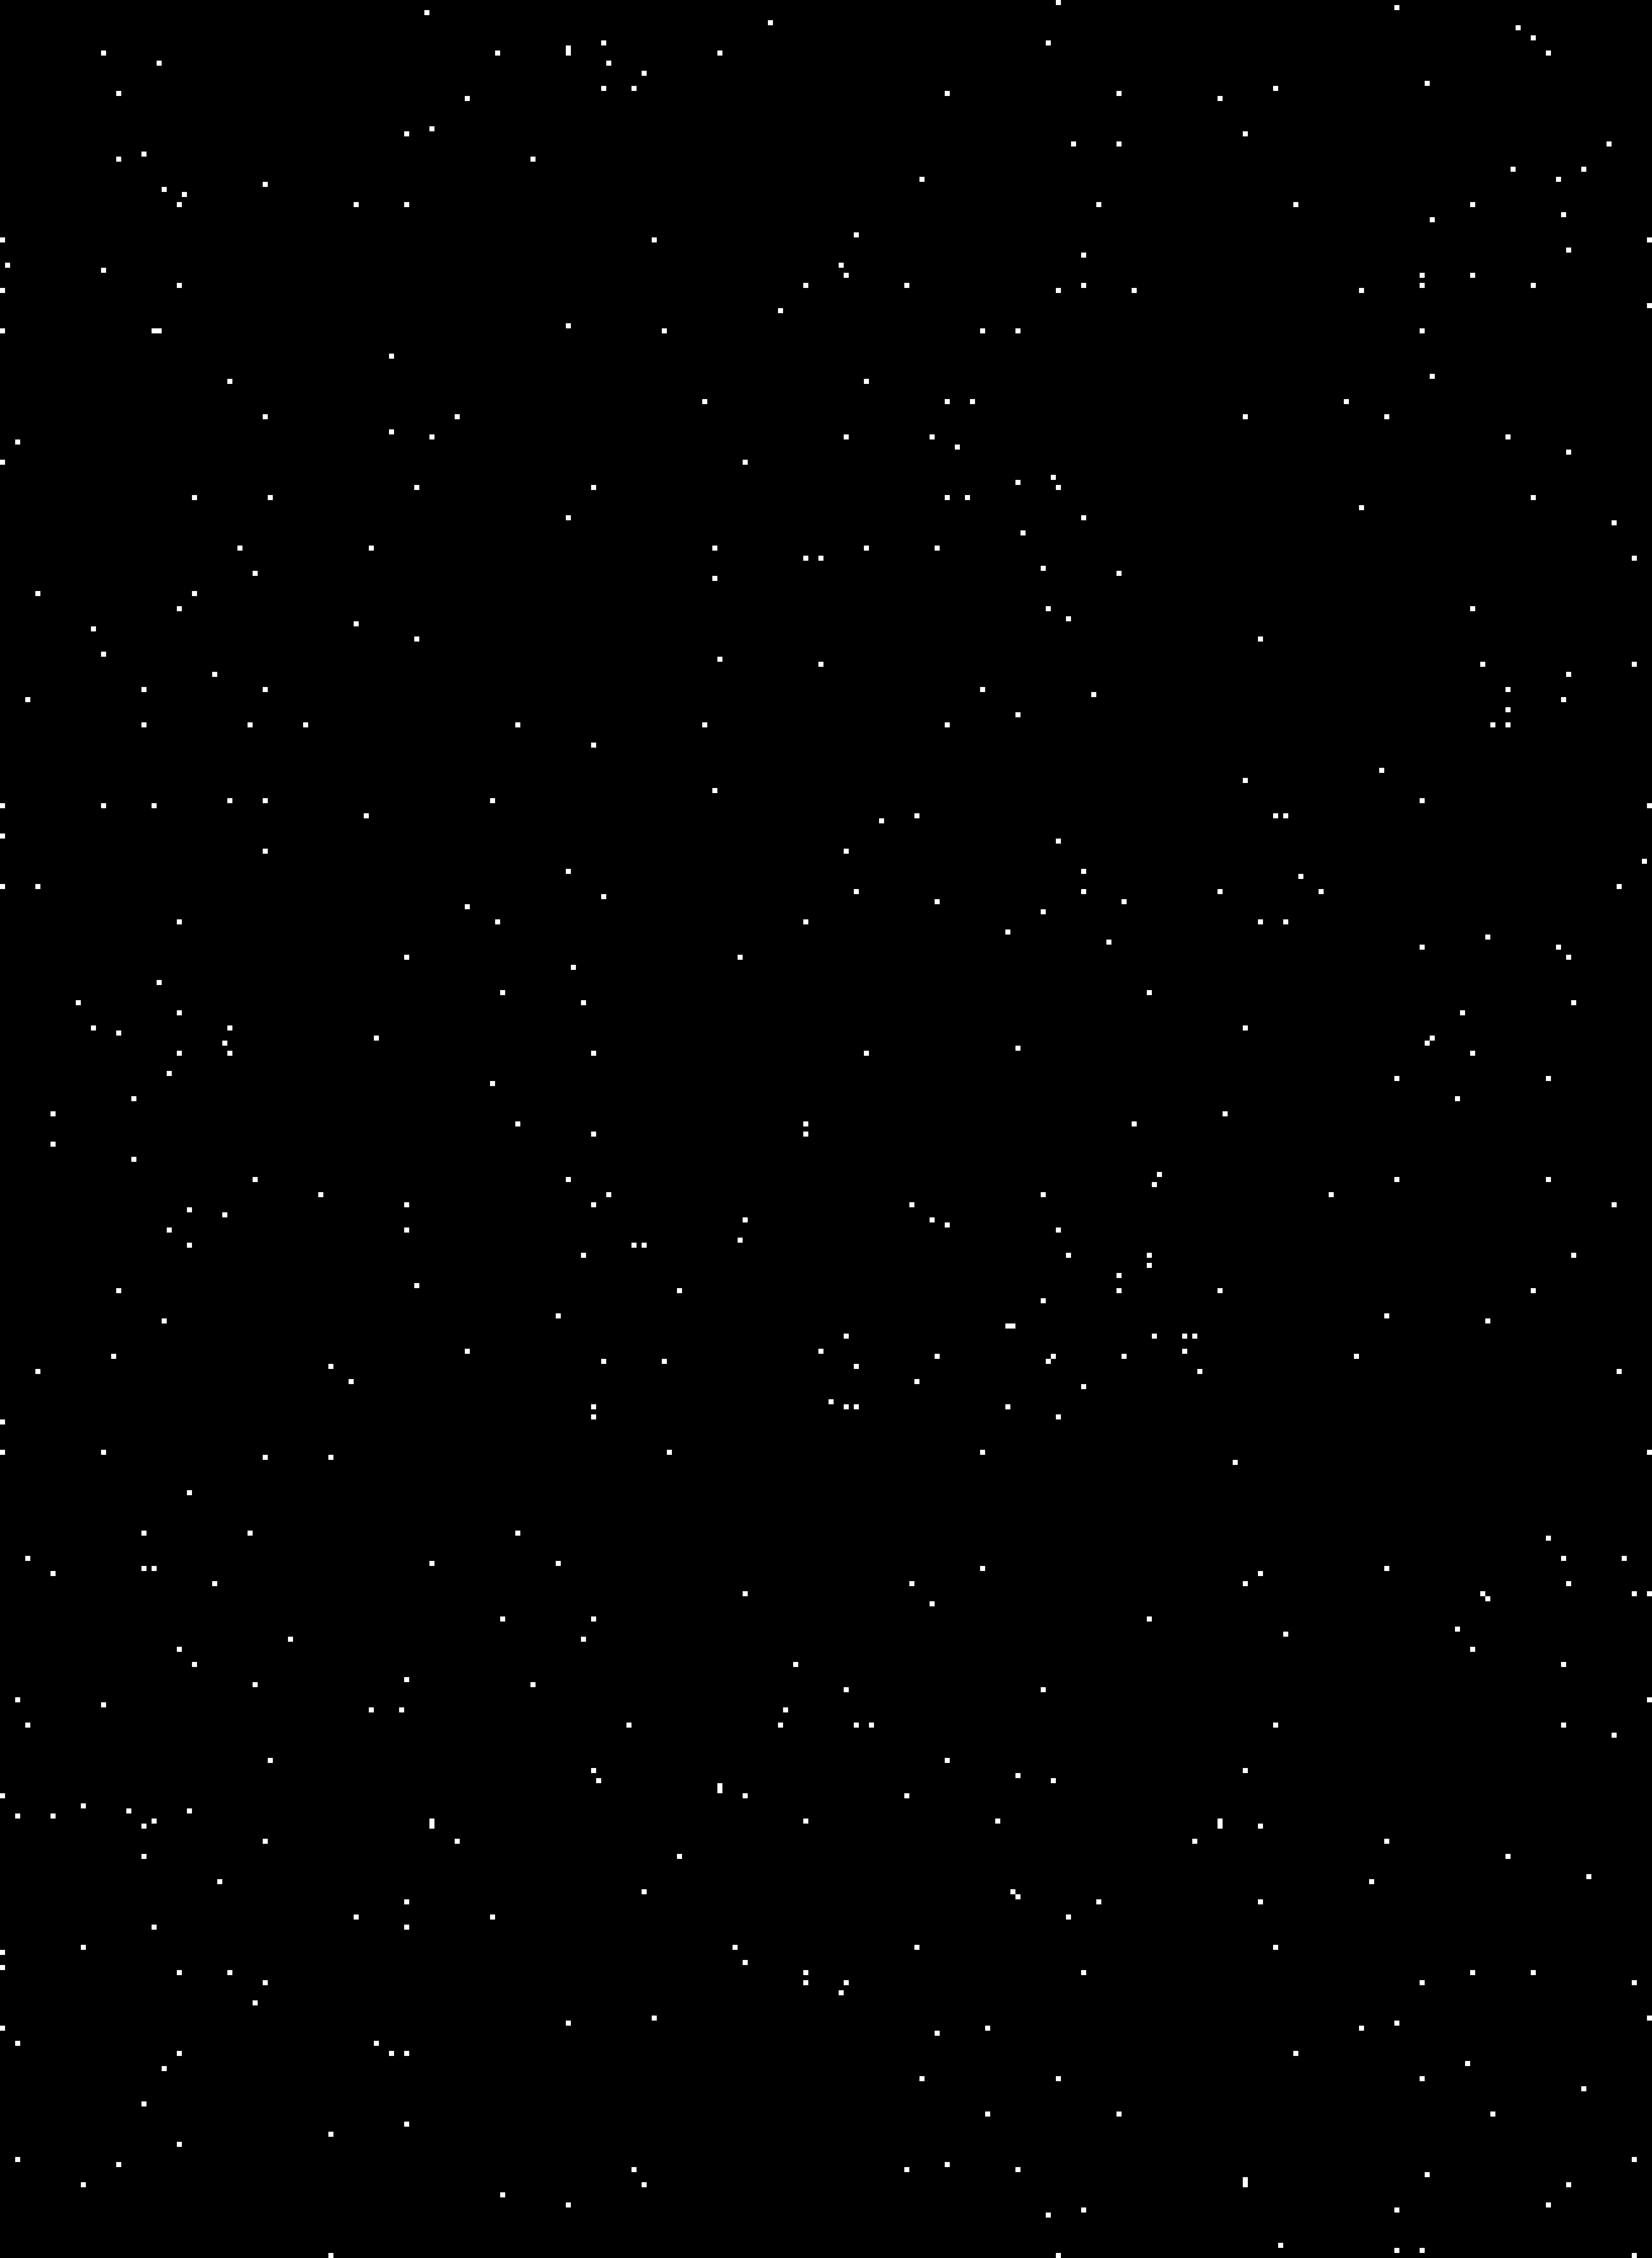

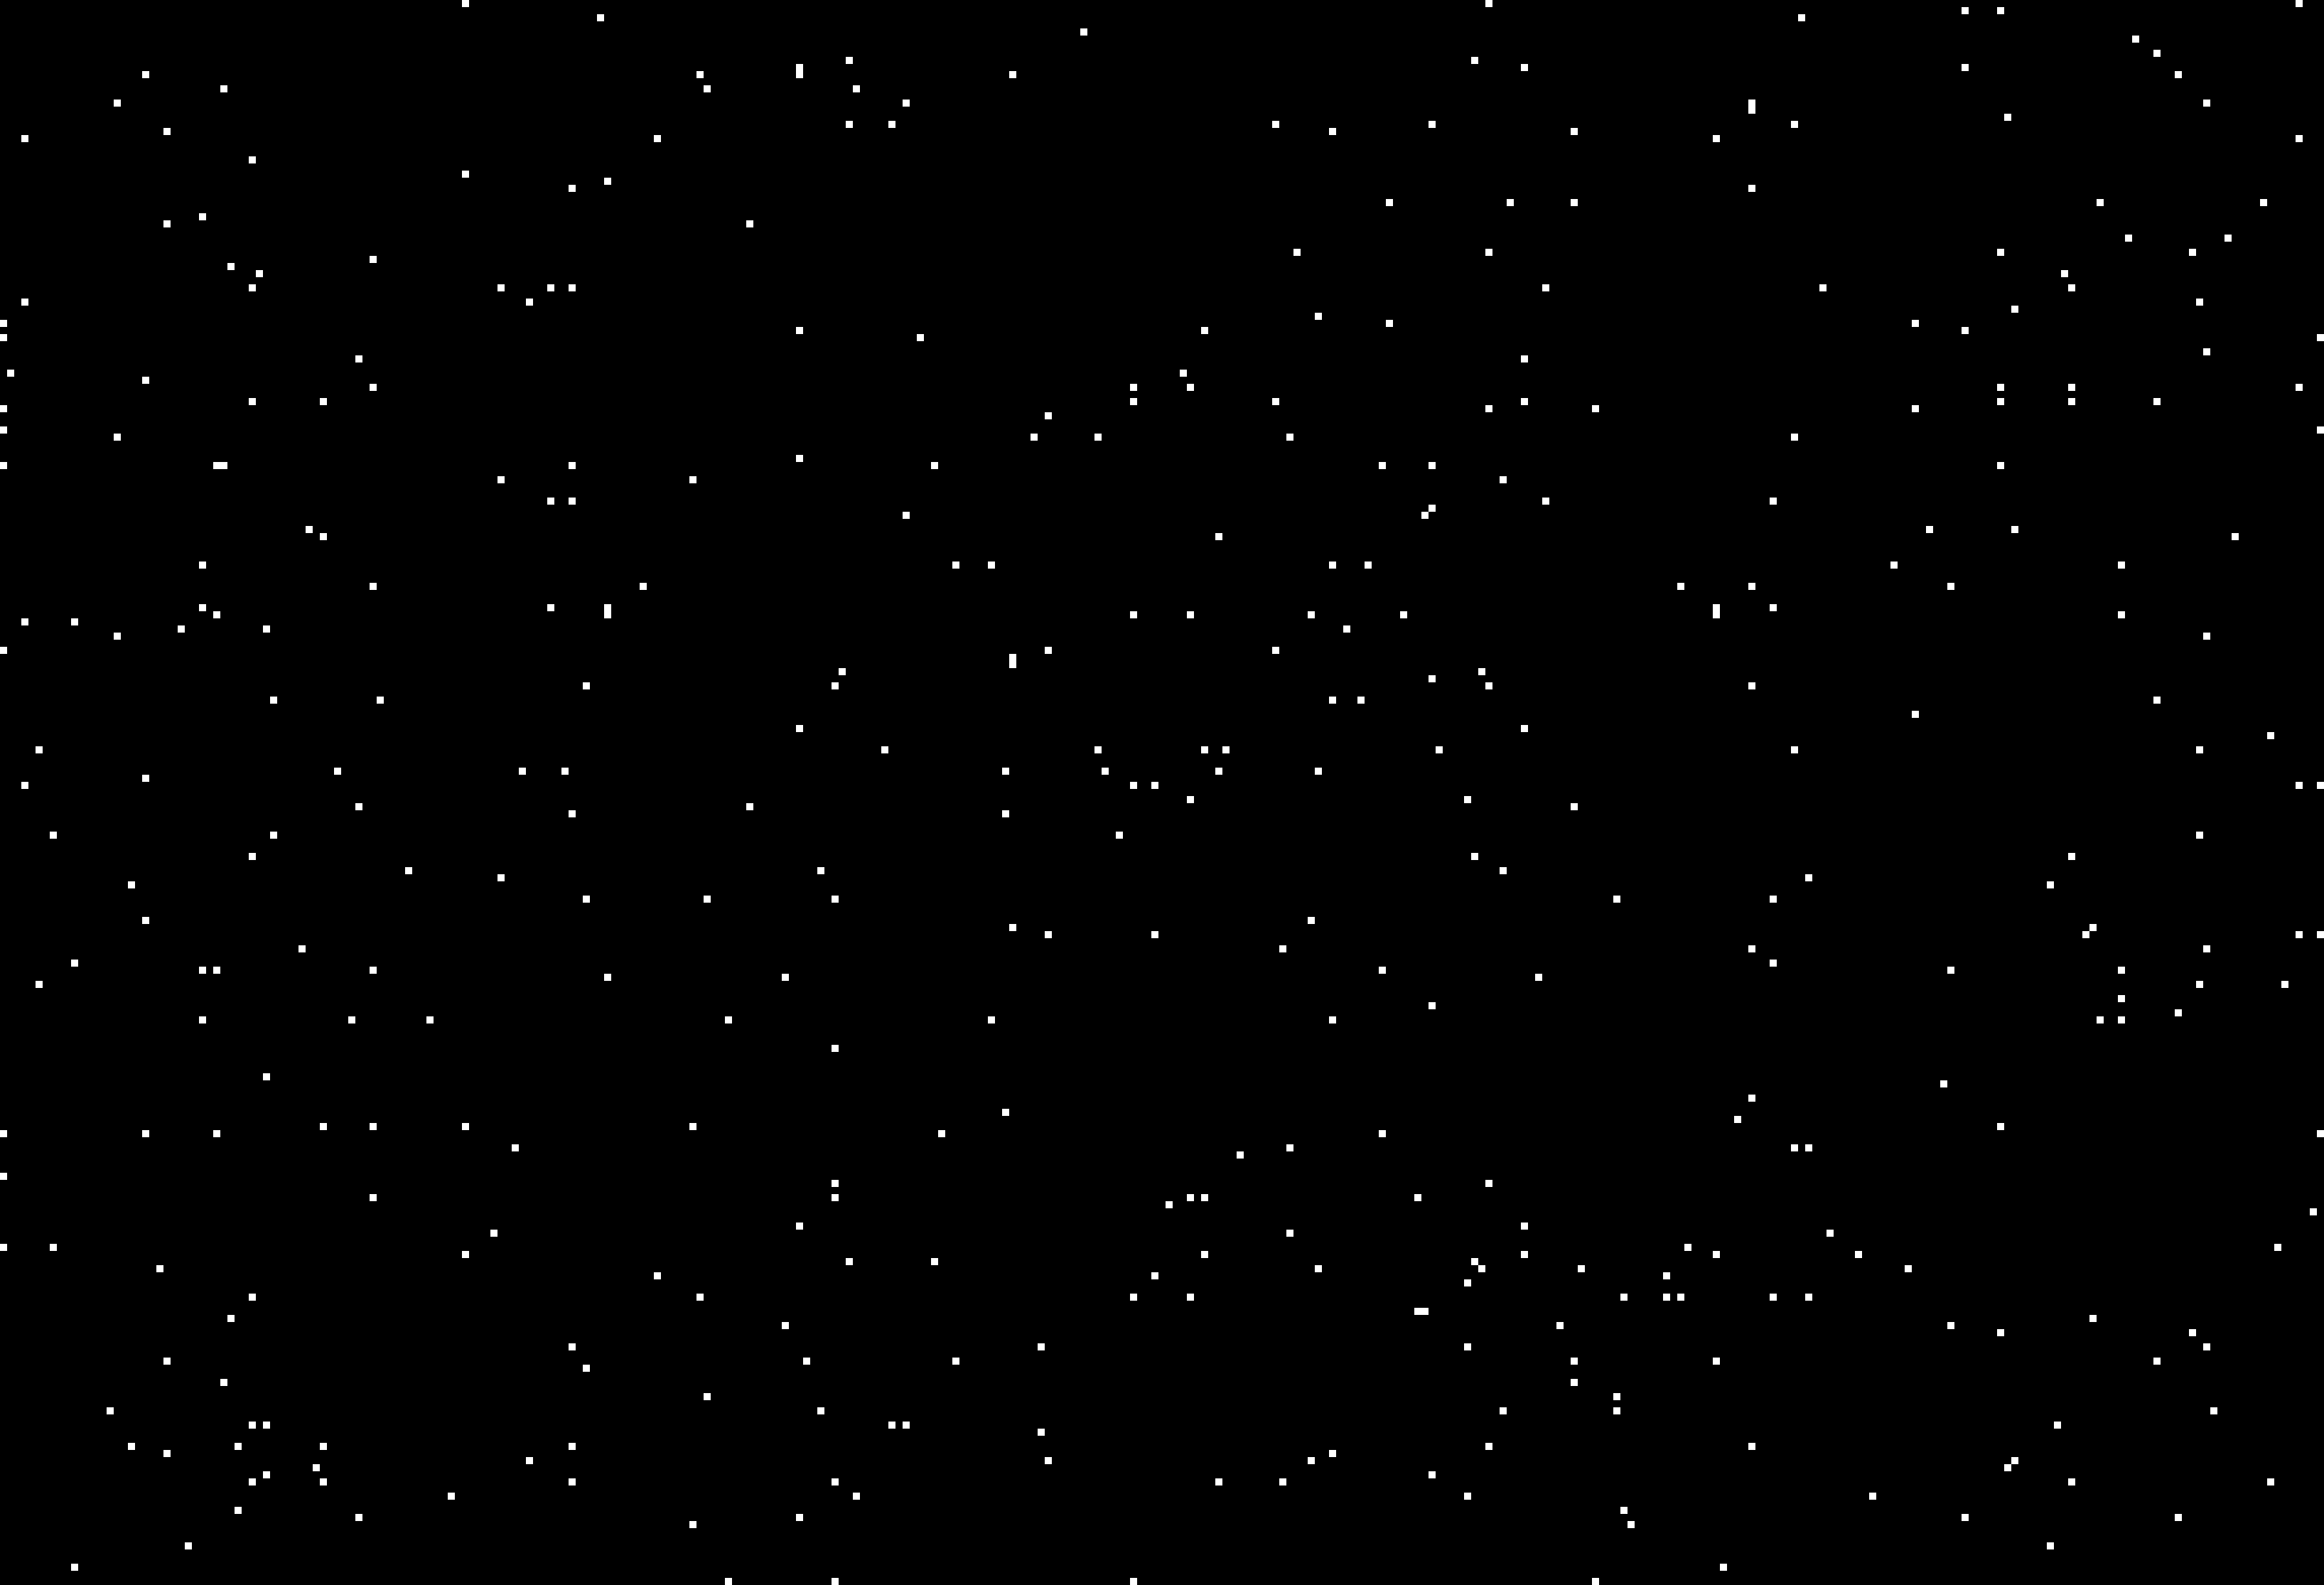

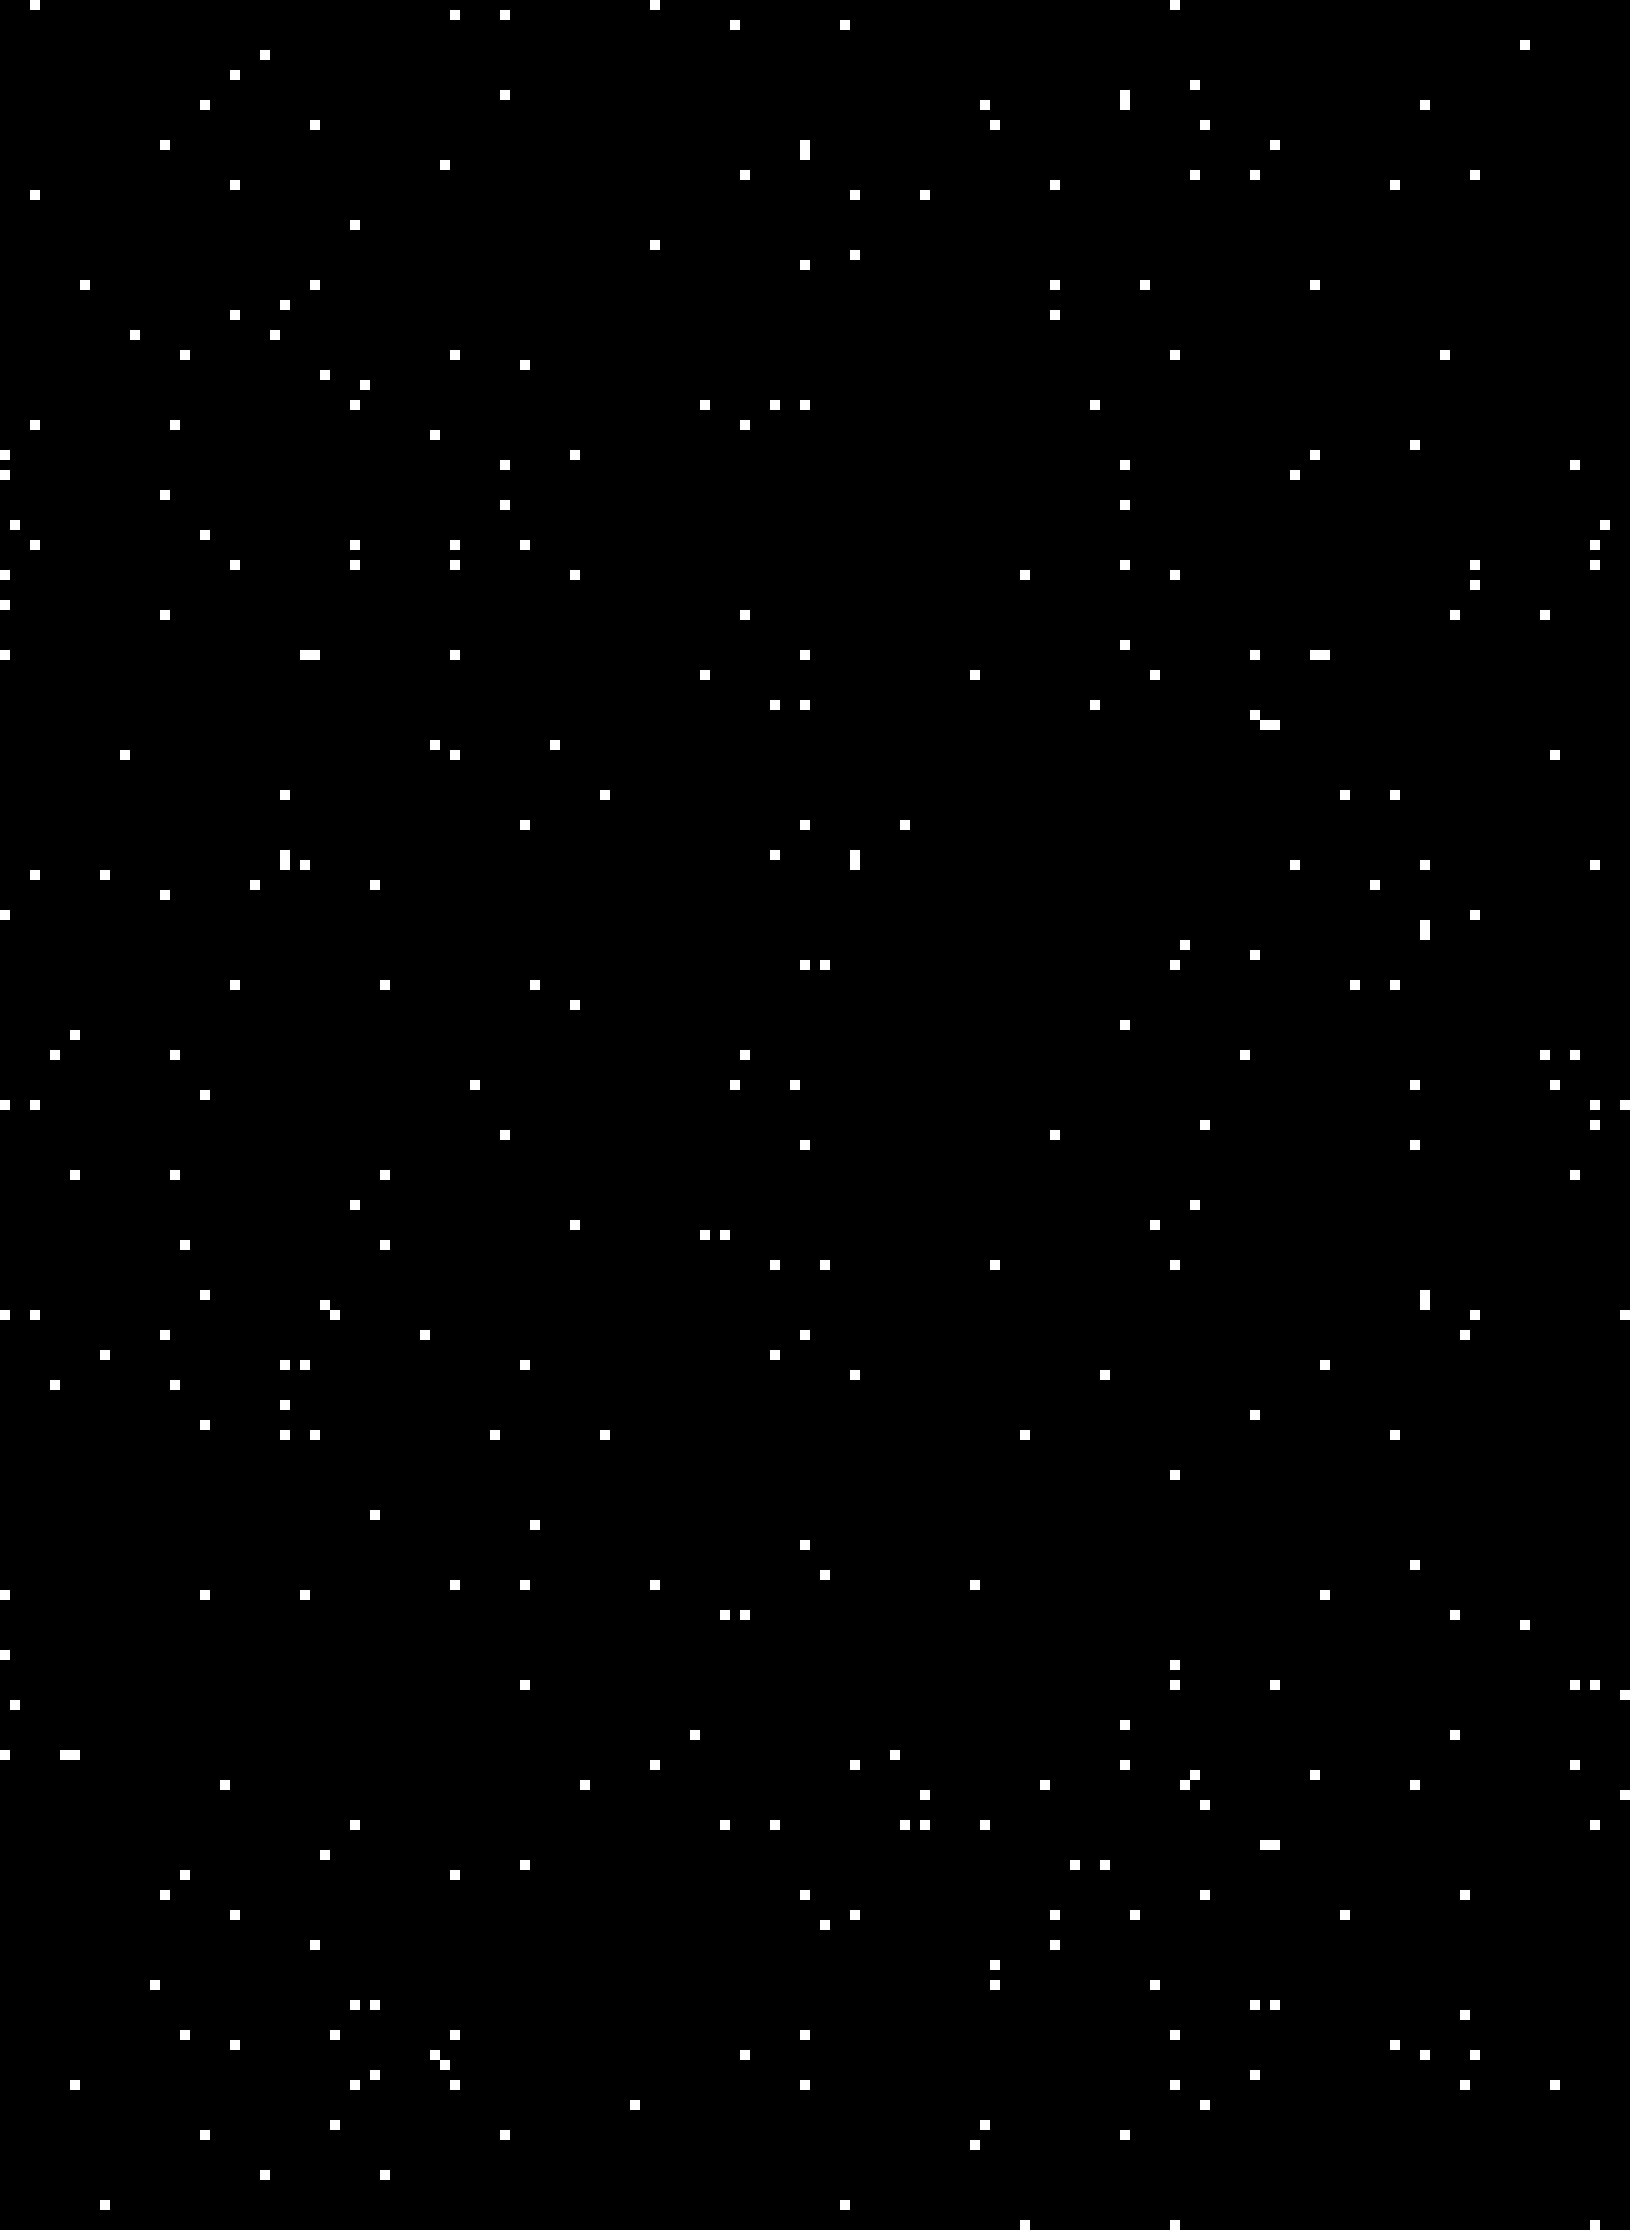

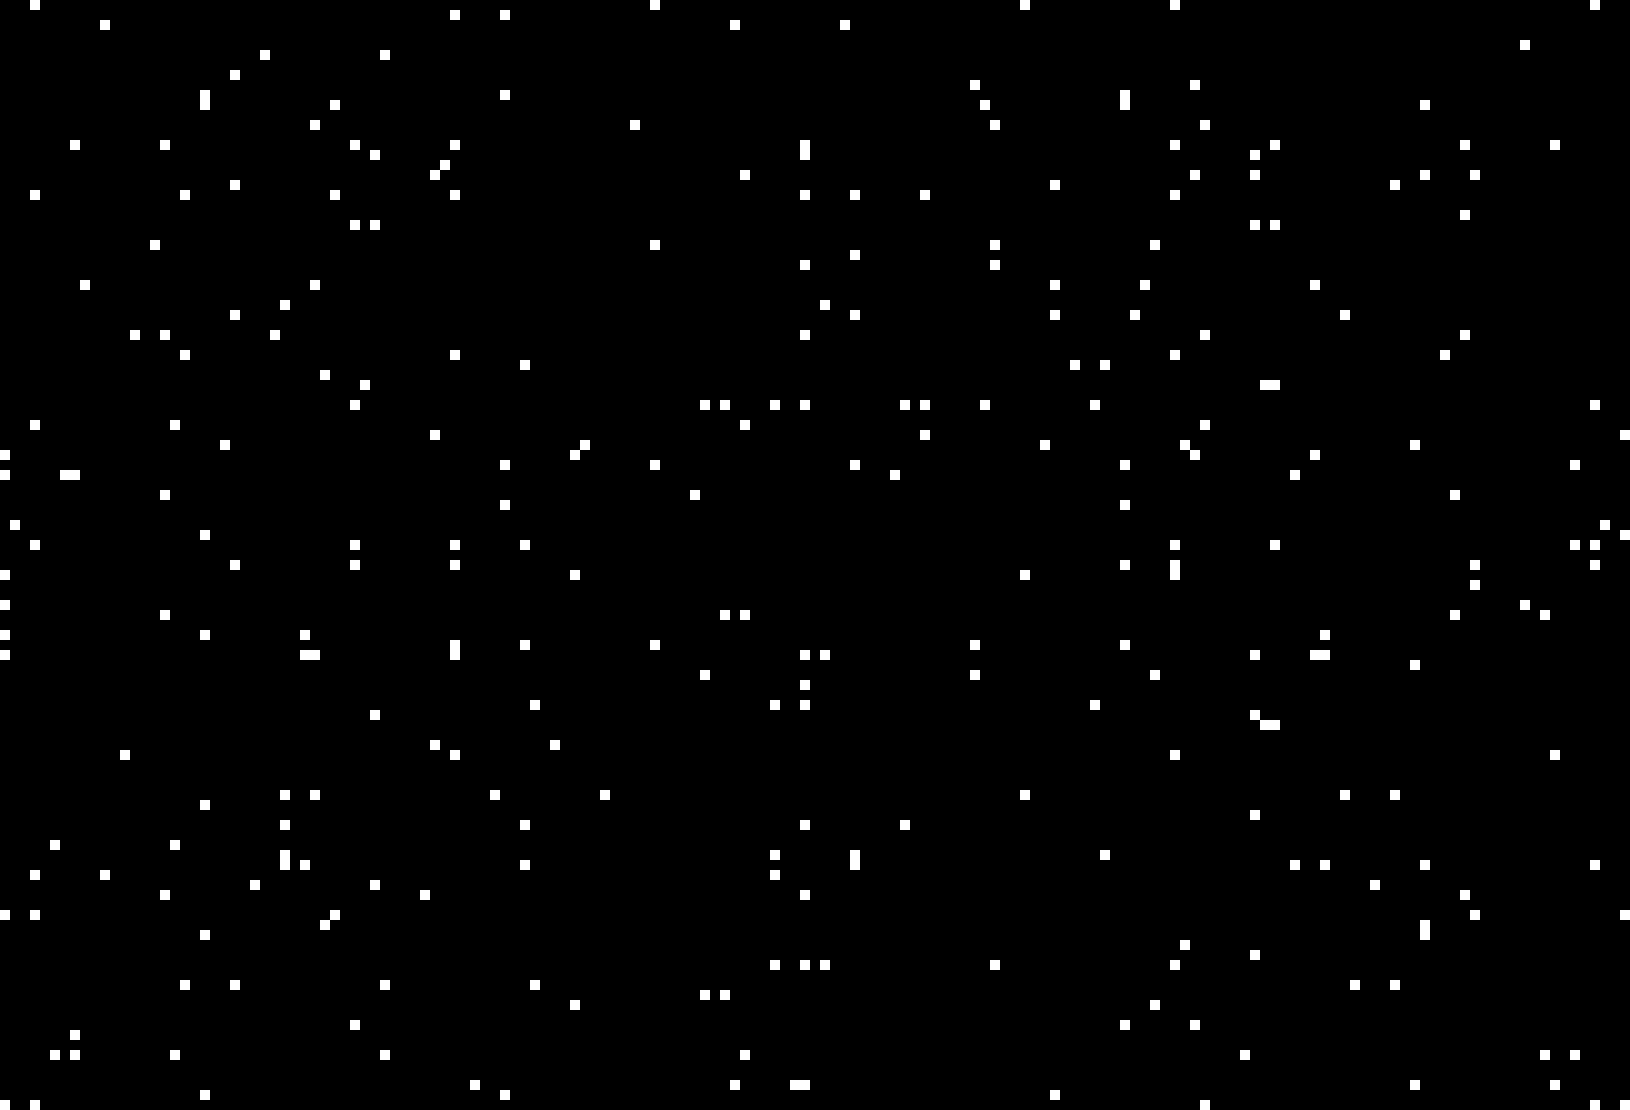

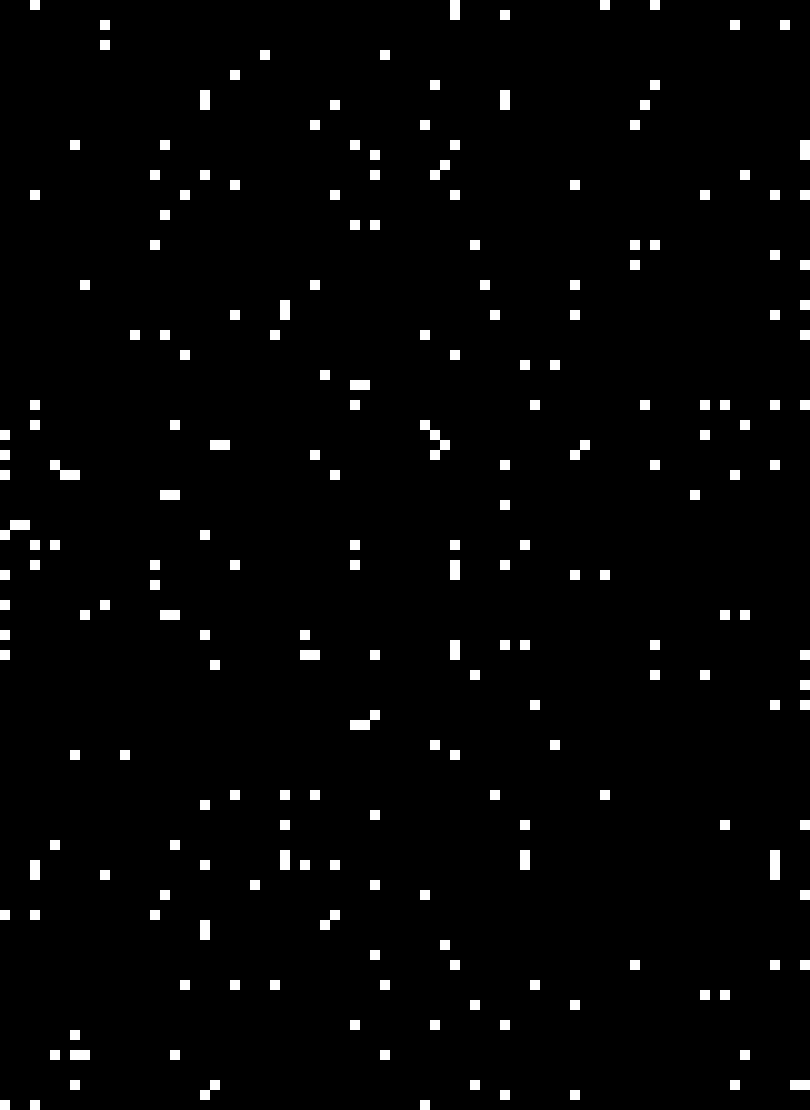

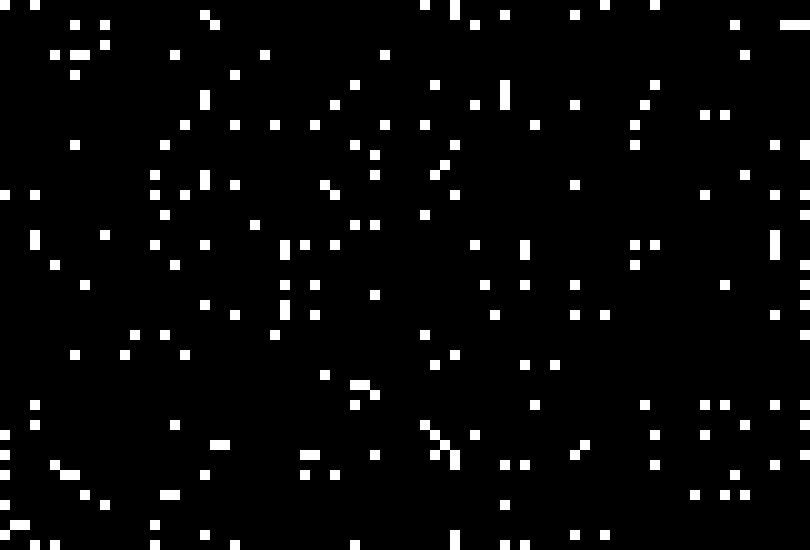

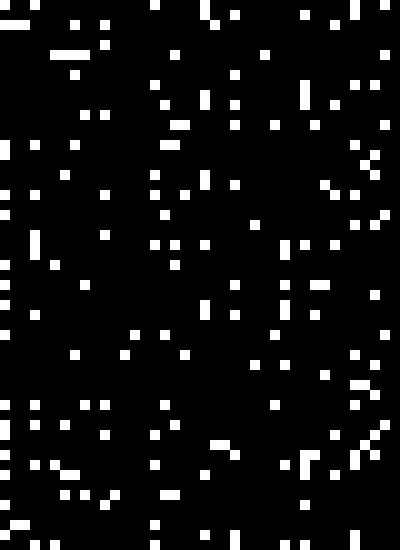

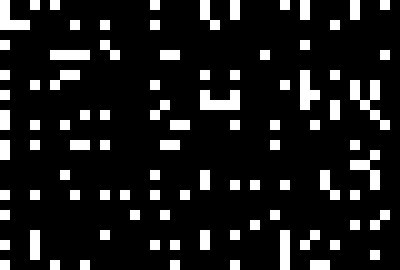

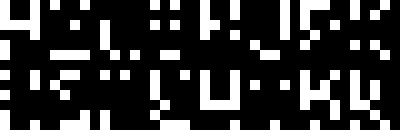

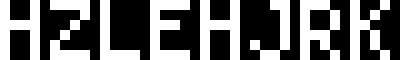

In [4]:
from IPython.display import display

for res in paper_folds:
    display(res)
